In [43]:
import numpy as np
import scipy.linalg as sc
import matplotlib.pyplot as plt
from scipy import signal
from MRPy import MRPy
import pandas as pd
import scipy.stats as st
import gzip   as gz

Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# PEC00144: Experimental Methods in Civil Engineering


### Trabalho Final: Shear Building

[1.    Introdução](#section_1)  
[2.    Modelo Reduzido](#section_2)  
[2.1   Propriedades do Modelo](#section_21)  
[2.1.1 Geometria e Material](#section_211)  
[2.2.2 Shear Building](#section_222)  
[2.2   Frequências e Modos de Vibração](#section_22)  
[3.    Modelo Real](#section_3)  
[3.1   Propriedades do Modelo](#section_31)  
[3.1.1 Geometria e Material](#section_311)  
[3.2.2 Shear Building](#section_322)  
[3.2   Frequências e Modos de Vibração](#section_32)  
[4.    Excitação Harmônica](#section_4)  
[4.1   Materiais Utilizados](#section_4.1)  
[4.2.1 Raspberry Pi Zero](#section_421)  
[4.2.2 Servo](#section_422)  
[4.2.3 Acelerômetro](#section_423)  
[4.3   Ensaios](#section_43)  
[4.3.1 Frequência natural do modelo reduzido](#section_431)  
[4.3.2 Velocidade angular do servo](#section_432)  
[4.4   Desenvolvimento do Código](#section_44)  
[5.    Análise Estatística](#section_5)  


---
_Flávio Antônio Ferreira, Doutorando_   
_José Lucas Silva Borges, Mestrando_    
_Porto Alegre, RS, Brazil_ 


## 1. Introdução <a name="section_1"></a> 

Este trabalho no consiste no ensaio de um modelo reduzido existente, feito em aço, que representa um Shear Building de 2 pavimentos, onde será utilizado um servo-motor para excitar a estrutura em sua frequência natural. Na sequencia serão realizados os cálculos de uma estrutura real em concreto armado que poderia ser representada por esse modelo.

## 2. Modelo Real <a name="section_2"></a> 

### 2.1 Propriedades do Modelo <a name="section_21"></a>

### 2.1.1 Geometria e Material <a name="section_211"></a>  
O modelo real é dotado das seguintes características:

* Dimensões das Colunas:    
  $B \times H = 5 \times 20 {\rm mm}$  
* Altura das Colunas:    
  $L_{\rm 1} = 160  {\rm mm}$    
* Propriedades da Seção Transversal:    
  $A = 10{\rm mm}^2$ e $I = 208,3 \times 10^{-3}{\rm mm}^4$ <br>
* Peso Específico do Aço:    
  $\rho_{\rm s} = 7850 {\rm kg/m}^3$    
* Módulo de Elasticidade do Aço:    
  $E_{\rm s} = 205 \times 10^{9} {\rm N/m}^2$ 
* Rigidez à flexão:   
  $E_{\rm s}\times I = 4.27 \times 10^{-2} Nm^2 $
* Massa do Pavimento Superior:    
  $m_{\rm 1} = 114  {g}$ 
* Massa do Pavimento Inferior:    
  $m_{\rm 2} = 104  {g}$ 

<img src="resources/shear building1.png" alt="sag_tension" width="480px"/>
<img src="resources/shear building2.png" alt="sag_tension" width="480px"/>


### 2.1.2 Shear Building <a name="section_212"></a>  

<img src="resources/shear building1.png" alt="sag_tension" width="480px"/>
<img src="resources/shear building2.png" alt="sag_tension" width="480px"/>


### 2.2 Frequências e Modos de Vibração <a name="section_22"></a>  



### Parâmetros Iniciais

In [21]:
#PILARRES
Ec=30*10**9
L = 4
h = 0.15
b = 0.220480598
Ip = (b*h**3)/12

Ir = 2*Ip
EIr = Ec*Ir

k  = 12*EIr/L/L/L

m1 = 30000
m2 = m1*.821825125

### Matrizes de Rigidez e Massa

In [22]:
# Stiffness coefficients in N/m
K = np.array ([[ 2*k, -2*k], 
               [-2*k,  4*k]])


# Lumped mass matrix in kg


M = np.array([ [m1,  0,], 
               [0,  m2,]])

print ("Matriz de rigidez\n",K)
print ("Matriz de Massa (lumped)\n",M)

Matriz de rigidez
 [[ 1395228.78421875 -1395228.78421875]
 [-1395228.78421875  2790457.5684375 ]]
Matriz de Massa (lumped)
 [[30000.          0.     ]
 [    0.      24654.75375]]


### Cálculo das Frequências e Modos de Vibração

First vibration mode:   0.69Hz, [ 0.858  0.514]
Second vibration mode:  1.89Hz, [-0.441  0.897]
First mode modal mass is:  28589.51kg
Second mode modal mass is: 25696.64kg


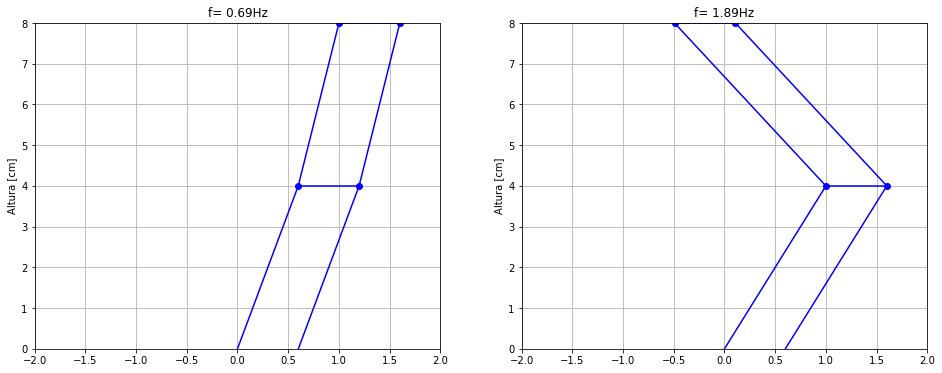

In [23]:
# Uses scipy to solve the standard eigenvalue problem
w2, Phi = sc.eig(K, M)

# Ensure ascending order of eigenvalues
iw  = w2.argsort()
w2  = w2[iw]
Phi = Phi[:,iw]

# Eigenvalues to vibration frequencies
wk  = np.sqrt(np.real(w2)) 
fk  = wk/2/np.pi

print('First vibration mode:  {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[0], *Phi[:,0]))
print('Second vibration mode: {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[1], *Phi[:,1]))

## Plotagem dos 3 primeiros modos de vibração da estrutura
plt.figure(1, figsize=(16,6))
x = np.linspace(0,2*L,3)

for k in range(2):
    pk = np.zeros(3)
    pk[1:] = Phi[::-1,k]
    pk /=np.max(np.abs(pk))
    plt.subplot(1,2,k+1)
    
    ## Linhas Horizontais
    for n in range(2):
        o = np.linspace(pk[n+1],pk[n+1]+.6,2)
        y1 = np.ones(2)*n*L+L
        plt.plot(o, y1, 'b')
    
    ## Pontos
    plt.plot(pk[1:],x[1:],'bo')
    plt.plot(pk[1:]+.6, x[1:], 'bo')
    
    ## Linhas Verticais
    plt.plot(pk,x,'b')
    plt.plot(pk+.6, x,'b')

    plt.xlim(-2, 2); plt.ylabel("Altura [cm]");
    plt.ylim( 0.0, 2*L+.01);
    plt.title('f= {0:3.2f}Hz'.format(fk[k]));
    plt.grid(True)
    
Mk = np.diag(np.dot(Phi.T, np.dot(M, Phi)))

print('First mode modal mass is:  {0:7.2f}kg'.format(Mk[0]))
print('Second mode modal mass is: {0:7.2f}kg'.format(Mk[1]))

## 2. Modelo Reduzido <a name="section_2"></a> 

### 2.1 Propriedades do Modelo <a name="section_21"></a>

### 2.1.1 Geometria e Material <a name="section_211"></a>  
O modelo reduzido a ser utilizado tem as seguintes caracterísitcas:

* Dimensões das Colunas:    
  $B \times H = 5 \times 20 {\rm mm}$  
* Altura das Colunas:    
  $L_{\rm 1} = 160  {\rm mm}$    
* Propriedades da Seção Transversal:    
  $A = 10{\rm mm}^2$ e $I = 208,3 \times 10^{-3}{\rm mm}^4$ <br>
* Peso Específico do Aço:    
  $\rho_{\rm s} = 7850 {\rm kg/m}^3$    
* Módulo de Elasticidade do Aço:    
  $E_{\rm s} = 205 \times 10^{9} {\rm N/m}^2$ 
* Rigidez à flexão:   
  $E_{\rm s}\times I = 4.27 \times 10^{-2} Nm^2 $
* Massa do Pavimento Superior:    
  $m_{\rm 1} = 114  {g}$ 
* Massa do Pavimento Inferior:    
  $m_{\rm 2} = 104  {g}$ 

<img src="resources/shear building1.png" alt="sag_tension" width="480px"/>
<img src="resources/shear building2.png" alt="sag_tension" width="480px"/>


### 2.1.2 Shear Building <a name="section_212"></a>  

<img src="resources/shear building1.png" alt="sag_tension" width="480px"/>
<img src="resources/shear building2.png" alt="sag_tension" width="480px"/>


### 2.2 Frequências e Modos de Vibração <a name="section_22"></a>  



### Parâmetros Iniciais

In [174]:
L  = 0.16
#EI = 2.05e11*(0.02*0.0005**3)/12
EI = 0.71e11*((0.02*0.0006**3)/12)
k  = 12*EI/L/L/L

m1 = 0.12880952
m2 = 0.1058589

### Matrizes de Rigidez e Massa

In [175]:
# Stiffness coefficients in N/m
K = np.array ([[ 2*k, -2*k], 
               [-2*k,  4*k]])


# Lumped mass matrix in kg


M = np.array([ [m1,  0,], 
               [0,  m2,]])

print ("Matriz de rigidez\n",K)
print ("Matriz de Massa (lumped)\n",M)

Matriz de rigidez
 [[ 149.765625 -149.765625]
 [-149.765625  299.53125 ]]
Matriz de Massa (lumped)
 [[0.12880952 0.        ]
 [0.         0.1058589 ]]


### Cálculo das Frequências e Modos de Vibração

First vibration mode:   3.44Hz, [ 0.858  0.514]
Second vibration mode:  9.45Hz, [-0.441  0.897]
First mode modal mass is:     0.12kg
Second mode modal mass is:    0.11kg


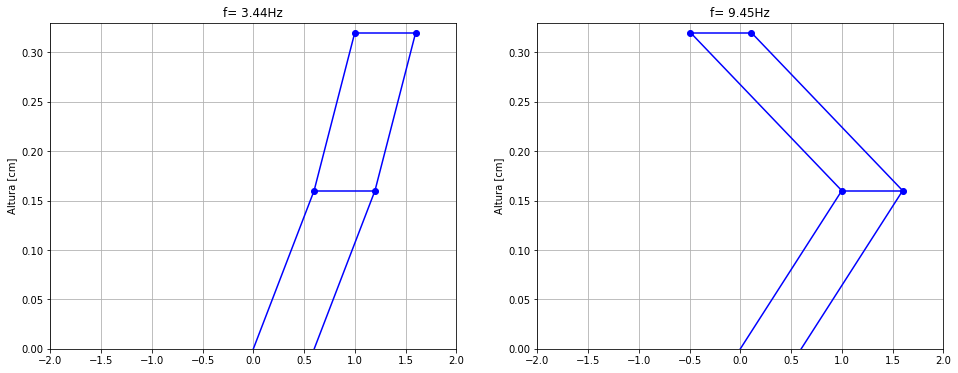

In [176]:
# Uses scipy to solve the standard eigenvalue problem
w2, Phi = sc.eig(K, M)

# Ensure ascending order of eigenvalues
iw  = w2.argsort()
w2  = w2[iw]
Phi = Phi[:,iw]

# Eigenvalues to vibration frequencies
wk  = np.sqrt(np.real(w2)) 
fk  = wk/2/np.pi

print('First vibration mode:  {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[0], *Phi[:,0]))
print('Second vibration mode: {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[1], *Phi[:,1]))

## Plotagem dos 3 primeiros modos de vibração da estrutura
plt.figure(1, figsize=(16,6))
x = np.linspace(0,2*L,3)

for k in range(2):
    pk = np.zeros(3)
    pk[1:] = Phi[::-1,k]
    pk /=np.max(np.abs(pk))
    plt.subplot(1,2,k+1)
    
    ## Linhas Horizontais
    for n in range(2):
        o = np.linspace(pk[n+1],pk[n+1]+.6,2)
        y1 = np.ones(2)*n*L+L
        plt.plot(o, y1, 'b')
    
    ## Pontos
    plt.plot(pk[1:],x[1:],'bo')
    plt.plot(pk[1:]+.6, x[1:], 'bo')
    
    ## Linhas Verticais
    plt.plot(pk,x,'b')
    plt.plot(pk+.6, x,'b')

    plt.xlim(-2, 2); plt.ylabel("Altura [cm]");
    plt.ylim( 0.0, 2*L+.01);
    plt.title('f= {0:3.2f}Hz'.format(fk[k]));
    plt.grid(True)
    
Mk = np.diag(np.dot(Phi.T, np.dot(M, Phi)))

print('First mode modal mass is:  {0:7.2f}kg'.format(Mk[0]))
print('Second mode modal mass is: {0:7.2f}kg'.format(Mk[1]))

## Modelo reduzido

In [24]:
# Importing pandas dataframe with dimension exponents for relevant quantities
DimData = pd.read_excel('resources/DimData.xlsx', sheet_name='DimData', index_col=0)
pi = np.pi;

In [25]:
ABC    = ['L', 'a', 'm']           
LMT    = ['L', 'M', 'T']           
base   =  DimData.loc[ABC, LMT]    
i_base =  np.linalg.inv(base)      

print(base)
#print(i_base)

   L  M  T
L  1  0  0
a  1  0 -2
m  0  1  0


In [26]:
λ_L    =  1/25               # Escala de comprimento do modelo real
λ_a    =  1/1                # Escala de aceleração (gravidade)
λ_m   =   128.880952/(30*10**6)        # Escala de massa

In [27]:
par    = ['f', 'EI', 'm', 'P']                    # selected scales to be calculated
npar   =  len(par)                           # number of quantities
DimMat =  DimData.loc[par, LMT]              # the dimensional matrix

print(DimMat)
#print(i_base)                               

    L  M  T
f   0  0 -1
EI  3  1 -2
m   0  1  0
P   2  1 -3


In [28]:
scales =  np.tile([λ_L, λ_a, λ_m],(npar,1))  # prepare for calculations

NewMat = pd.DataFrame(data    = np.dot(DimMat, i_base),
                      index   = DimMat.index,
                      columns = ABC)
print(NewMat)

      L    a    m
f  -0.5  0.5  0.0
EI  2.0  1.0  1.0
m   0.0  0.0  1.0
P   0.5  1.5  1.0


In [29]:
[λ_f, λ_EI, λ_m, λ_P]  = np.prod(scales**NewMat, axis=1);

print('Escala de Frequencia:  λ_f  = 1:{0:4.2f}'.format(1/λ_f),  '\n'
      'Escala de Rigidez:     λ_EI = 1:{0:4.10f}'.format(1/λ_EI), '\n'
      'Escala de Massa:       λ_m  = 1:{0:4.10f}'.format(1/λ_m),  '\n'
      'Escala de Potencia:    λ_P  = 1:{0:4.10f}'.format(1/λ_P))

Escala de Frequencia:  λ_f  = 1:0.20 
Escala de Rigidez:     λ_EI = 1:145483096.6797948182 
Escala de Massa:       λ_m  = 1:232772.9546876718 
Escala de Potencia:    λ_P  = 1:1163864.7734383587


In [30]:
print('Massa do Pavimento:      {0:5.3f}kg'.format(m1*λ_m))
print('Rigidez da Estrutura:    {0:5.10f}Nm²'.format(EIr*λ_EI))
print('Comprimento da Coluna:   {0:5.2f}m'.format(L*λ_L))
print('Primeira Frequencia:     {0:5.2f}Hz'.format(fk[0]*λ_f))
print('Segunda Frequencia:      {0:5.2f}Hz'.format(fk[1]*λ_f))

Massa do Pavimento:      0.129kg
Rigidez da Estrutura:    0.0255741744Nm²
Comprimento da Coluna:    0.16m
Primeira Frequencia:      3.44Hz
Segunda Frequencia:       9.45Hz


### Construção do modelo

In [31]:
Ea=71*10**9
Ia=EIr*λ_EI/Ea
b = 0.02
h = (12*Ia/b)**(1/3)
L = 0.16


m1 = 0.12880952
m2 = 0.1058589

Mr = np.array([ [m1,  0,], 
               [0,  m2,]])

### Análise de Propagação de Erro

In [32]:
m_e = [ 0.55, 0.60, 0.65, 0.60, 0.65, 0.60, 0.60, 0.65, 0.55, 0.6, 0.6, 0.6]        #espessura das colunas em mm
m_L = [20.60,20.40,20.90,21.00,20.70,20.70,20.30,20.10,20.20,20.4,20.3,20.3]   #largura das colunas mm

mi_e = np.mean(m_e)
sigma_e = np.std(m_e)

mi_L = np.mean(m_L)
sigma_L = np.std(m_L)

print('--------------------------------------------','\n',
      'Espessura média da coluna:           {0:5.5f}mm'.format(mi_e),'\n',
      'Desvio padrão da espessura:         {0:5.5f}mm'.format(sigma_e),'\n',
      'Largura média da coluna:            {0:5.5f}mm'.format(mi_L),'\n',
      'Desvio padrão da largura:          {0:5.5f}mm'.format(sigma_L),'\n',
      '--------------------------------------------')

-------------------------------------------- 
 Espessura média da coluna:           0.60417mm 
 Desvio padrão da espessura:         0.03200mm 
 Largura média da coluna:            20.49167mm 
 Desvio padrão da largura:          0.27221mm 
 --------------------------------------------


In [33]:
#----------------------------------#
Ea = 71*10**9
h = st.norm(mi_e/1000,sigma_e/1000)
b = st.norm(mi_L/1000,sigma_L/1000) 
    
def autoval(E,b,h,L,m1,m2):
    I = (b*h**3)/12
    K = 12*Ea*I/(L*L*L)
    Kr = np.array([[2*K,-2*K],
                   [-2*K, 4*K]])
    
    Mr = np.array([ [m1,  0,], 
               [0,  m2,]])
    w21,Phi1 = sc.eig(Kr,Mr)



    iw = w21.argsort()
    w21 = w21[iw]                       
    Phi1 = Phi1[:,iw]

    wr = np.real(w21)
    wk = np.sqrt(w21)
    fk = wk/(2*np.pi)
    
    return fk[0],fk[1]
#------------------------------------#
n = 100000
hh = h.rvs(n)
bb = b.rvs(n)

fi = []
fi2 = []

for i in range(n):
    
    f1,f2 = autoval(Ea,bb[i],hh[i],L,m1,m2)
    fi += [f1]
    fi2 += [f2]
    
mi_f = np.mean(fi)
sigma_f = np.std(fi)
print('---------------------------------------','\n',
      'Valor médio da frequência:    {0:5.2f}hz'.format(np.real(mi_f)),'\n',
      'Valor do erro:                {0:5.2f}hz' .format(sigma_f),'\n',
      'Coeficiente de variação:      {0:5.2f}%'.format(sigma_f/np.real(mi_f)*100),'\n',
      '--------------------------------------')


mi_f2 = np.mean(fi2)
sigma_f2 = np.std(fi2)
print('---------------------------------------','\n',
      'Valor médio da frequência:    {0:5.2f}hz'.format(np.real(mi_f2)),'\n',
      'Valor do erro:                {0:5.2f}hz' .format(sigma_f2),'\n',
      'Coeficiente de variação:      {0:5.2f}%'.format(sigma_f2/np.real(mi_f2)*100),'\n',
      '--------------------------------------')



--------------------------------------- 
 Valor médio da frequência:     3.52hz 
 Valor do erro:                 0.28hz 
 Coeficiente de variação:       7.96% 
 --------------------------------------
--------------------------------------- 
 Valor médio da frequência:     9.67hz 
 Valor do erro:                 0.77hz 
 Coeficiente de variação:       7.96% 
 --------------------------------------


## 2. Funcionamento do Motor (servo)

Velocidade angular constante ($\phi$)

#### 2.1 Definição da Velocidade Angular ($\omega \phi$)  
20 medições com o transferidor (fazer um tranferidor de papel 360°).  
Adotar um sleeptime que faça a posição final ser prox de 180°

In [40]:
## Geração de sinal triangular

                    # Frequência do sinal triangular (Hz)  
Td1 = 1/np.real(mi_f)
Td2 = 1/np.real(mi_f2)
Tt =  2                    # Tempo total de análise

N1 = int(Tt/(Td1/50))                   # Discretização do tempo
N2 = int(Tt/(Td2/50))


t1=np.linspace(0,Tt,N1+1)
t2=np.linspace(0,Tt,N2+1)

V = 600                     # Velocidade angular (graus/s)
D1 = V*(Td1/4)
D2 = V*(Td2/4)

triangle1 = signal.sawtooth(2*np.pi*fk[0]*(t1+Td1/4), 0.5)
triangle2 = signal.sawtooth(2*np.pi*fk[1]*(t2+Td2/4), 0.5)
𝜙1 = triangle1*D1                # Deslocamento Angular [graus] 
𝜙2 = triangle2*D2

Lh = 0.1
ux1 = Lh*np.sin(np.radians(𝜙1))
ux2 = Lh*np.sin(np.radians(𝜙2))


def derivative (f, t):
    f_d = np.zeros(f.size-1) 
    for i in range (f.size-1):
        f_d[i] = (f[i+1]-f[i])/h



v1=np.diff(ux1, n=1)/(t1[1])
a1=np.diff(v1, n=1)/(t1[1])

v2=np.diff(ux2, n=1)/(t2[1])
a2=np.diff(v2, n=1)/(t2[1])



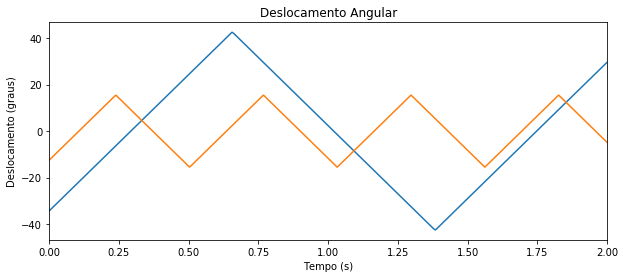

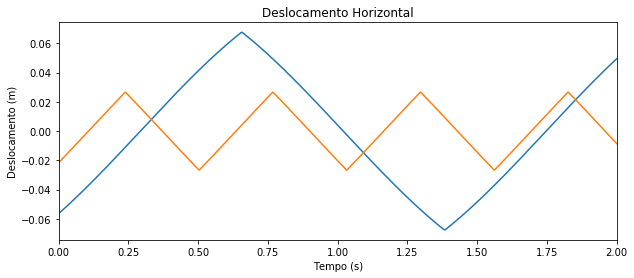

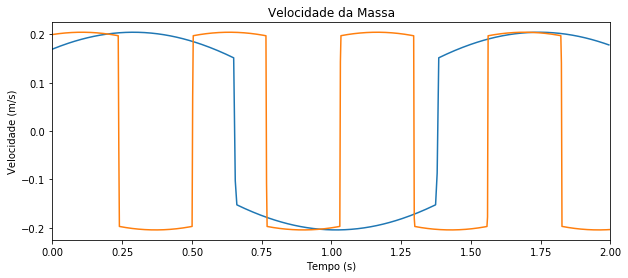

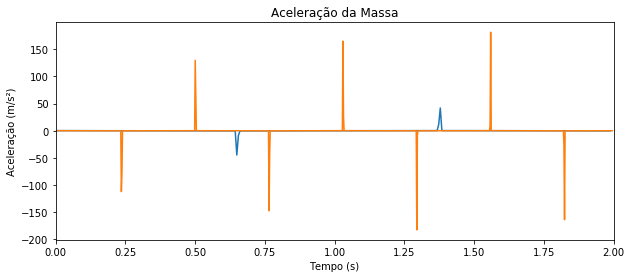

In [41]:
plt.figure(2, figsize=(10, 4), clear=True)
plt.plot(t1, 𝜙1)
plt.plot(t2, 𝜙2)
plt.title("Deslocamento Angular", )
plt.xlim(0, Tt);   plt.xlabel('Tempo (s)') 
plt.ylabel('Deslocamento (graus)')

plt.figure(3, figsize=(10, 4), clear=True)
plt.plot(t1, ux1)
plt.plot(t2, ux2)
plt.title("Deslocamento Horizontal", )
plt.xlim(0, Tt);   plt.xlabel('Tempo (s)') 
plt.ylabel('Deslocamento (m)')

plt.figure(4, figsize=(10, 4), clear=True)
plt.plot(t1[:-1], v1)
plt.plot(t2[:-1], v2)
plt.title("Velocidade da Massa")
plt.xlim(0, Tt);
plt.xlabel('Tempo (s)'); plt.ylabel('Velocidade (m/s)')

plt.figure(5, figsize=(10, 4), clear=True)
plt.plot(t1[:-2],a1)
plt.plot(t2[:-2],a2)
plt.title("Aceleração da Massa")
plt.xlim(0, Tt);
plt.xlabel('Tempo (s)'); plt.ylabel('Aceleração (m/s²)');

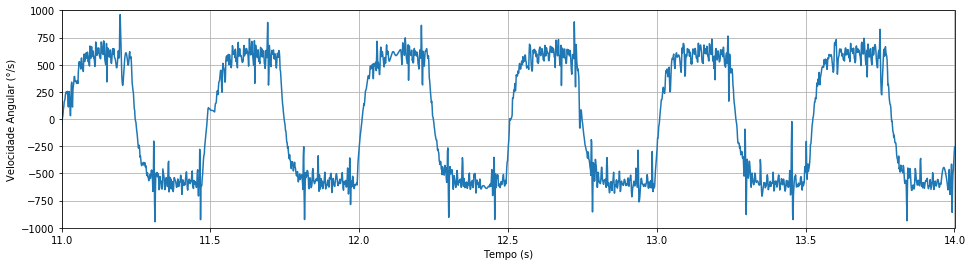

In [47]:
veloc_ang='leitura_excitador/2019-11-15__16-04-57'

with gz.open(veloc_ang+'.csv.gz', 'rb') as target:
    data =  np.genfromtxt(target, 
                          delimiter=',')
    ti   =  data[1:,0] - data[1,0]
    
a=MRPy.from_resampling(ti,(data[1:,1:])/32.8)

az   = MRPy(a[0], a.fs)
t    = a.t_axis()

plt.figure(4, figsize=(16, 4), clear=True)
plt.plot(t, az[0])

plt.xlim(11, 14);  plt.xlabel('Tempo (s)') 
plt.ylim(-1000, 1000);
plt.ylabel('Velocidade Angular (°/s)') 

plt.grid(True) 


plt.grid(True)

In [56]:
V=[]
n=0
for i in range (np.size(t)):
    if az[0,i]>=600-150:
        n+=1
V=np.ones(n)        
n=0
for i in range (np.size(t)):
    if az[0,i]>=600-150:
        V[n]=az[0,i]
        n+=1

mi_V = np.mean(V)
sigma_V = np.std(V)

print('--------------------------------------------','\n',
      'Velocidade angular:           {0:5.5f}°'.format(mi_V),'\n',
      'Desvio padrão da velocidade angular:         {0:5.5f}°'.format(sigma_V),'\n',
      '--------------------------------------------')

-------------------------------------------- 
 Velocidade angular:           591.38861° 
 Desvio padrão da velocidade angular:         69.47974° 
 --------------------------------------------


### 2.2 Definição de Parâmetros

## 3. Excitação Harmônica

## Fase 02 - Atenuador de massa

## Modelo 01 com atenuador de massa passivo

In [10]:
# System properties
f0 =  fk[0]                      # natural frequency (Hz)
k0 =  m1*(2*np.pi*f0)**2         # system stiffness (N/m)
zt =  0.01                       # same damping ratio for all

# Damper design
mD =  (m1+m2)*0.04                        # damper mass 4% of total (kg)
mr =  mD/(m1+m2)
sm =  np.sqrt(mr)

fr = (np.sqrt(1 - mr/2)/(1 + mr) + np.sqrt(1 - 2*zt*zt) - 1) \
       - (2.375 -  1.034*sm -  0.426*mr)*zt*sm \
       - (3.730 - 16.903*sm + 20.496*mr)*zt*zt*sm

fD =  1.00*fr*f0                 # Tsai and Lin (1993) - increase to test!!!
kD =  mD*(2*np.pi*fD)**2         # tuned damper stiffness (N/m)

print('Ideal damper frequency: {0:5.2f}Hz'.format(fD))
print (fk[0])
print(mD)

Ideal damper frequency:  3.26Hz
3.4377493617522488
0.009386736800000002


In [11]:
# Matriz de rigidez do amortecedor
KD = np.array([[    kD, -kD ],    # stiffness matrix
               [   -kD,  kD ]])

n=1                                                      #Grau de liberdade onde o amortecedor será inserido
K2=np.insert(np.insert(K, n, 0, axis=1), n, 0, axis=0)  #Inserir uma linha e uma coluna de zeros (matriz de ordem 12)
M2=np.insert(np.insert(M, n, 0, axis=1), n, 0, axis=0)

for i in range (2):                                      #Adição da matriz KD em K2
    for j in range (2):
        K2[n+j][n+i]+=KD[j][i]

M2[n][n]=mD                                              #Adição da massa da mola em M2


print ("Matriz de rigidez do amortecedor\n", KD,"\n")
print ("Matriz de rigidez do modelo\n", K2,"\n")
print ("Matriz de massa do modelo\n", M2,"\n")

Matriz de rigidez do amortecedor
 [[ 3.93128293 -3.93128293]
 [-3.93128293  3.93128293]] 

Matriz de rigidez do modelo
 [[ 149.765625      0.         -149.765625  ]
 [   0.            3.93128293   -3.93128293]
 [-149.765625     -3.93128293  303.46253293]] 

Matriz de massa do modelo
 [[0.12880952 0.         0.        ]
 [0.         0.00938674 0.        ]
 [0.         0.         0.1058589 ]] 



In [12]:
# Uses scipy to solve the standard eigenvalue problem
w2, Phi2 = sc.eig(K2, M2)

# Ensure ascending order of eigenvalues
iw  = w2.argsort()
w2  = w2[iw]
Phi2 = Phi2[:,iw]

# Eigenvalues to vibration frequencies
wk2  = np.sqrt(np.real(w2)) 
fk2  = wk2/2/np.pi

print('First vibration mode:  {0:5.2f}Hz, [{1:6.3f} {2:6.3f} {3:6.3f}]'.format(fk2[0], *Phi2[:,0]))
print('Second vibration mode: {0:5.2f}Hz, [{1:6.3f} {2:6.3f} {3:6.3f}]'.format(fk2[1], *Phi2[:,1]))
print('Third vibration mode: {0:5.2f}Hz,  [{1:6.3f} {2:6.3f} {3:6.3f}]'.format(fk2[2], *Phi2[:,2]))

First vibration mode:   3.10Hz, [-0.140 -0.986 -0.094]
Second vibration mode:  3.60Hz, [ 0.358 -0.912  0.201]
Third vibration mode:  9.49Hz,  [ 0.434  0.119 -0.893]


In [13]:
Mk2 = np.diag(np.dot(Phi2.T, np.dot(M2, Phi2)))
print('First mode modal mass is:  {0:7.2f}kg'.format(Mk2[0]))
print('Second mode modal mass is: {0:7.2f}kg'.format(Mk2[1]))
print('Third mode modal mass is: {0:7.2f}kg'.format(Mk2[2]))

First mode modal mass is:     0.01kg
Second mode modal mass is:    0.03kg
Third mode modal mass is:    0.11kg


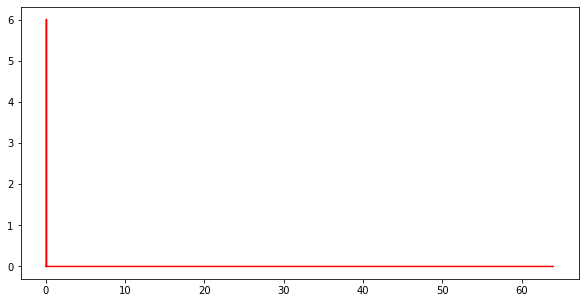

In [14]:
Td =  64.                          # time discretization parameters
N  =  10240
fs =  N/Td

F0 =  0.1*k0                      # quasi-static response is 1cm
t  =  np.linspace(0, Td, N)        # time domain
s  =  np.sin(2*np.pi*fk[0]*t)      # sine wave ressonant with 1st mode
F = [F0*signal.unit_impulse(N, 10), np.zeros(s.shape), np.zeros(s.shape)]

# Modal force as MRPy object
Fk =  MRPy(np.dot(Phi2.T, F), fs=fs)

# Normalize by modal masses:
for k in range(2):
    Fk[k,:] /= Mk2[k]

    
plt.figure(1, figsize=(10, 5), clear=True)
plt.plot(t, F[0],"r");


R.M.S. displacement of system mass:  1.074mm
R.M.S. displacement of damper:       3.862mm
R.M.S. displacement of system mass:  0.624mm


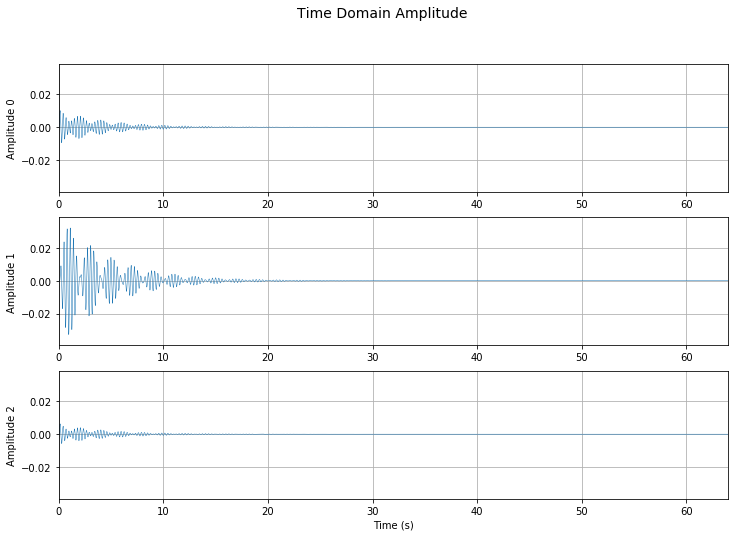

In [15]:
uk =  Fk.sdof_Duhamel(fk2, zt)           # solve by Duhamel
ut =  MRPy(np.dot(Phi2, uk), fs=uk.fs)   # back from modal space

ut.plot_time();


print('R.M.S. displacement of system mass: {0:6.3f}mm'.format(ut[0].std()*1000))
print('R.M.S. displacement of damper:      {0:6.3f}mm'.format(ut[1].std()*1000))
print('R.M.S. displacement of system mass: {0:6.3f}mm'.format(ut[2].std()*1000))


## Fase 02 - Active Mass Damper

### Tentativa 01  

$$m_1\ddot{x_1}(t)+c_1\dot{x_1}(t)+k_1x_1(t)=f(t)-u(t)$$  
$$m_2\ddot{x_2}(t)=u(t)$$

Para o modelo reduzido de 2 GDL

In [16]:
## Geração de sinal triangular

# Discretização do tempo
N = 42100
tm = 1/fk[0]
Td =  N*tm/1000
t=np.linspace(0,Td,N+1)
fs =  N/Td
zt=0.01

triangle = signal.sawtooth(2*np.pi*fk[0]*t, 0.5)
u=triangle                # Amplitude em Deslocamento [m] 
u=u[80:]
t=t[:-80]


e = 2.718281
dec = e**(-zt*wk[0]*t)
u2 = u*dec

v2=np.diff(u2, n=1)
a2=np.diff(u2, n=2)

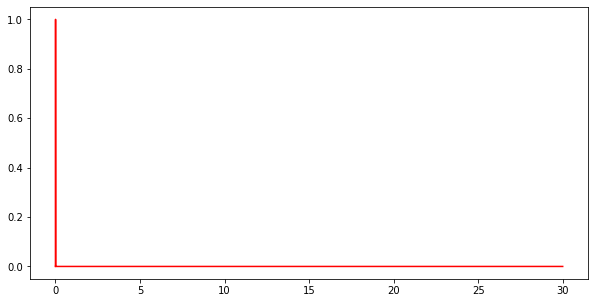

In [17]:
Td =  30.                          # time discretization parameters
N  =  42019
fs =  N/Td

F0 =  1                      # quasi-static response is 1cm
t  =  np.linspace(0, Td, N)        # time domain
s  =  np.sin(2*np.pi*fk[0]*t)      # sine wave ressonant with 1st mode
f = signal.unit_impulse(N, 10)
F = [F0*f, np.zeros(s.shape)]

# Modal force as MRPy object
Fk =  MRPy(np.dot(Phi.T, F), fs=fs)

# Normalize by modal masses:
for k in range(2):
    Fk[k,:] /= Mk[k]
    
plt.figure(1, figsize=(10, 5), clear=True)
plt.plot(t, f,"r");


R.M.S. displacement of system mass:  0.039mm
R.M.S. displacement of system mass:  0.024mm


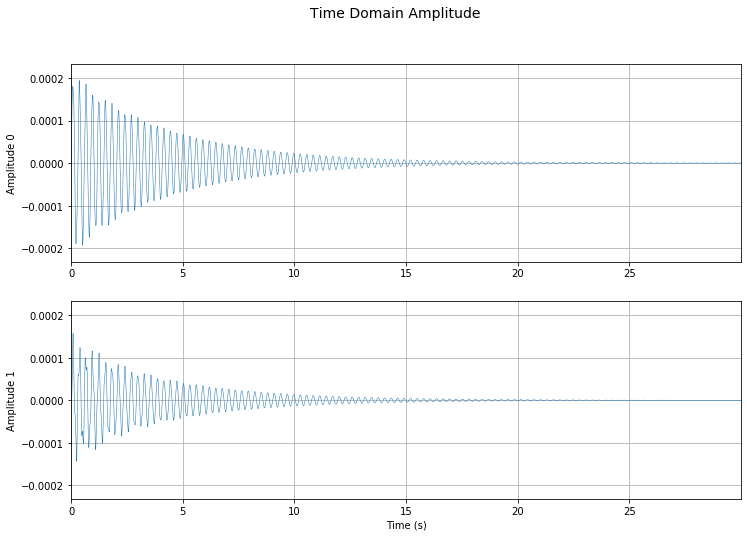

In [18]:
uk =  Fk.sdof_Duhamel(fk, zt)           # solve by Duhamel
ut =  MRPy(np.dot(Phi, uk), fs=uk.fs)   # back from modal space

ut.plot_time();


print('R.M.S. displacement of system mass: {0:6.3f}mm'.format(ut[0].std()*1000))
print('R.M.S. displacement of system mass: {0:6.3f}mm'.format(ut[1].std()*1000))

In [19]:
## Geração de sinal triangular

# Discretização do tempo
N = 42100
tm = 1/fk[0]
Td =  N*tm/1000
t=np.linspace(0,Td,N+1)
fs =  N/Td
zt=0.01

triangle = signal.sawtooth(2*np.pi*fk[0]*t, 0.5)
u=triangle*D                # Amplitude em Deslocamento [m] 
u=u[80:]
t=t[:-80]


e = 2.718281
dec = e**(-zt*wk[0]*t)
u2 = u*dec

v2=np.diff(u2, n=1)
a2=np.diff(u2, n=2)





plt.figure(1, figsize=(10, 5), clear=True)
plt.plot(t, dec,"r");
print (fk[0])
print (u)

NameError: name 'D' is not defined

In [ ]:
plt.figure(2, figsize=(12, 4), clear=True)
plt.plot(t, u2)
plt.title("Deslocamento da Massa", )
plt.xlim(-.01, 10);   plt.xlabel('Tempo (s)') 
plt.ylabel('Deslocamento (m)')

plt.figure(3, figsize=(12, 4), clear=True)
plt.plot(t[:-1], v2)
plt.title("Velocidade da Massa")
plt.xlim(0, 10);
plt.xlabel('Tempo (s)'); plt.ylabel('Velocidade (m/s)')

plt.figure(4, figsize=(10, 4), clear=True)
plt.plot(t[:-2],a2)
plt.title("Aceleração da Massa")
plt.xlim(-.1, 10);
plt.xlabel('Tempo (s)'); plt.ylabel('Aceleração (m/s²)');
print (len(u))

In [ ]:

N  = 42021                  # length of time series
T  = Td                  # series total duration
f0 = 100                   # sine/cosine frequency (in Hertz)

k  = np.arange(0, N)   # required for f_k calculation
ti = k*T/N               # discrete time domain
fk = k/T                 # discrete frequency domain

ci = np.cos(2*np.pi*f0*ti)
Ck = np.fft.fft(a)


print (len(fk), len(Ck.real))
plt.figure(2, figsize=(8, 4), clear=True)
plt.plot(ti[:-2], a)
#plt.xlim( 0, T);  
plt.xlabel('time (s)') 
#plt.ylim(-2, 2);  
plt.ylabel('f(t)') 
plt.grid(True) 

plt.figure(3, figsize=(8, 6), clear=True)

plt.subplot(2,1,1)
plt.plot(fk[:-2], Ck.real)
plt.xlim( 2.5, 3);  
plt.xlabel('frequency (Hz)')
#plt.ylim(-N, N  );
plt.ylabel('Real(F_k)') 
plt.grid(True)

In [ ]:
f = 2
Tm = 1/f
n = int(Tm/0.001)
t = np.linspace(0, Tm, n)
a = np.sin(2*np.pi*f*t)

plt.figure(3, figsize=(8, 6), clear=True)
plt.plot(t, a);